## Khai báo thư viện

In [ ]:
# Import thư viện cơ bản cho xử lý dữ liệu và hệ thống
import os  
import random  
import warnings  
from pathlib import Path  

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Import thư viện âm thanh
import wave  
import librosa  
import librosa.display  

# Import TensorFlow / Keras
import tensorflow as tf  
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing.image import load_img, img_to_array  

# Import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report 

warnings.filterwarnings('ignore')  # Tắt cảnh báo không cần thiết để notebook gọn

# Thiết lập random seed để tái lập kết quả
SEED = 42  # Giá trị seed cố định
random.seed(SEED)  # Seed cho thư viện random
np.random.seed(SEED)  # Seed cho numpy
tf.random.set_seed(SEED)  # Seed cho tensorflow

print('Đã import thư viện và thiết lập seed thành công.')  # Thông báo hoàn tất

Đã import thư viện và thiết lập seed thành công.


## 9. Xây dựng mô hình CNN 

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

batch_size = 16
img_size_cnn = (128, 128)

train_ds = image_dataset_from_directory(
    thu_muc_cnn / 'train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size_cnn,
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    thu_muc_cnn / 'val',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size_cnn,
    shuffle=False
)

print('Class order:', train_ds.class_names)

Found 70 files belonging to 2 classes.
Found 30 files belonging to 2 classes.
Tên lớp theo thứ tự: ['HS', 'LS']


In [ ]:
# Xây dựng CNN cơ bản
so_lop = 2

cnn_model = models.Sequential([
    layers.Input(shape=(img_size_cnn[0], img_size_cnn[1], 3)),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(so_lop, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,585,410 (17.49 MB)

 Trainable params: 4,584,450 (17.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

epochs = 50

lich_su_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 629ms/step - accuracy: 0.5571 - loss: 1.7251 - val_accuracy: 0.5333 - val_loss: 1.4841 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.7571 - loss: 0.9431 - val_accuracy: 0.3667 - val_loss: 0.9223 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.6857 - loss: 1.0176 - val_accuracy: 0.5667 - val_loss: 0.7771 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.7000 - loss: 1.0449 - val_accuracy: 0.5333 - val_loss: 0.9896 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.7714 - loss: 0.7833 - val_accuracy: 0.5000 - val_loss: 1.1191 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.8286 - loss: 0.3407 - val_accuracy: 0.6667 - val_loss: 0.7506 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.8857 - loss:

## 10. Xây dựng mô hình MobileNetV2 (Transfer Learning)

In [ ]:
# Load lại dataset và preprocess theo chuẩn MobileNetV2
batch_size_mn = 8
img_size_mn = (128, 128)

train_ds_mn = image_dataset_from_directory(
    thu_muc_cnn / 'train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size_mn,
    image_size=img_size_mn,
    shuffle=True,
    seed=SEED
)

val_ds_mn = image_dataset_from_directory(
    thu_muc_cnn / 'val',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size_mn,
    image_size=img_size_mn,
    shuffle=False
)

train_ds_mn = train_ds_mn.map(lambda x, y: (preprocess_input(x), y))
val_ds_mn = val_ds_mn.map(lambda x, y: (preprocess_input(x), y))

Found 70 files belonging to 2 classes.
Found 30 files belonging to 2 classes.


In [ ]:
# Tạo model MobileNetV2
base_model = MobileNetV2(
    input_shape=(img_size_mn[0], img_size_mn[1], 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

mobilenet_model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train giai đoạn 1 (freeze)
early_stop_mn = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr_mn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

epochs_mn_1 = 50

lich_su_mn_1 = mobilenet_model.fit(
    train_ds_mn,
    validation_data=val_ds_mn,
    epochs=epochs_mn_1,
    callbacks=[early_stop_mn, reduce_lr_mn]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.4286 - loss: 1.1810 - val_accuracy: 0.5000 - val_loss: 0.9359 - learning_rate: 1.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5143 - loss: 1.1579 - val_accuracy: 0.5333 - val_loss: 0.8850 - learning_rate: 1.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5000 - loss: 1.2517 - val_accuracy: 0.5667 - val_loss: 0.8475 - learning_rate: 1.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3857 - loss: 1.0244 - val_accuracy: 0.6333 - val_loss: 0.8077 - learning_rate: 1.0000e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4857 - loss: 1.1430 - val_accuracy: 0.6333 - val_loss: 0.7685 - learning_rate: 1.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5714 - loss: 0.7943 - val_accuracy: 0.6333 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5857 - loss:

In [ ]:
# Fine-tune: mở một phần layer cuối
base_model.trainable = True

so_layer_mo = int(len(base_model.layers) * 0.2)
for layer in base_model.layers[:-so_layer_mo]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs_mn_2 = 20

lich_su_mn_2 = mobilenet_model.fit(
    train_ds_mn,
    validation_data=val_ds_mn,
    epochs=epochs_mn_2,
    callbacks=[early_stop_mn, reduce_lr_mn]
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.7000 - loss: 0.5913 - val_accuracy: 0.9333 - val_loss: 0.1984 - learning_rate: 1.0000e-05
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7286 - loss: 0.6155 - val_accuracy: 0.9333 - val_loss: 0.1753 - learning_rate: 1.0000e-05
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8143 - loss: 0.5340 - val_accuracy: 0.9333 - val_loss: 0.1577 - learning_rate: 1.0000e-05
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8000 - loss: 0.5548 - val_accuracy: 0.9333 - val_loss: 0.1459 - learning_rate: 1.0000e-05
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7571 - loss: 0.4728 - val_accuracy: 0.9333 - val_loss: 0.1391 - learning_rate: 1.0000e-05
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8143 - loss: 0.4146 - val_accuracy: 0.9333 - val_loss: 0.1324 - learning_rate: 1.0000e-05
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9286 - loss

## 11. Đánh giá mô hình


ĐÁNH GIÁ MÔ HÌNH: CNN cơ bản
Classification report:
              precision    recall  f1-score   support

          HS       0.73      0.73      0.73        15
          LS       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30



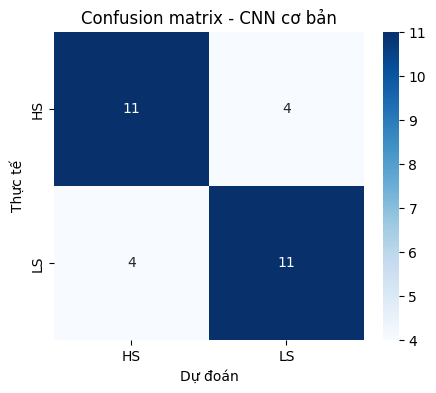


ĐÁNH GIÁ MÔ HÌNH: MobileNetV2
Classification report:
              precision    recall  f1-score   support

          HS       1.00      1.00      1.00        15
          LS       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



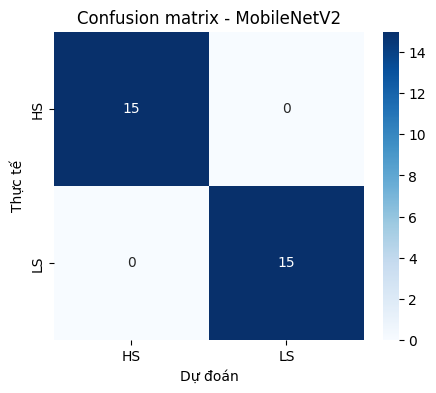

In [ ]:
def danh_gia_mo_hinh(model, dataset, ten_mo_hinh: str):
    y_thuc = []
    y_du_doan = []

    for batch_x, batch_y in dataset:
        du_doan = model.predict(batch_x, verbose=0)
        y_thuc.extend(batch_y.numpy().tolist())
        y_du_doan.extend(np.argmax(du_doan, axis=1).tolist())

    cm = confusion_matrix(y_thuc, y_du_doan)

    print('\n', '=' * 60)
    print('ĐÁNH GIÁ MÔ HÌNH:', ten_mo_hinh)
    print('=' * 60)
    print('Classification report:')
    print(classification_report(y_thuc, y_du_doan, target_names=['HS', 'LS']))

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['HS', 'LS'],
        yticklabels=['HS', 'LS']
    )
    plt.title(f'Confusion matrix - {ten_mo_hinh}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()


danh_gia_mo_hinh(cnn_model, val_ds, 'CNN cơ bản')
danh_gia_mo_hinh(mobilenet_model, val_ds_mn, 'MobileNetV2')

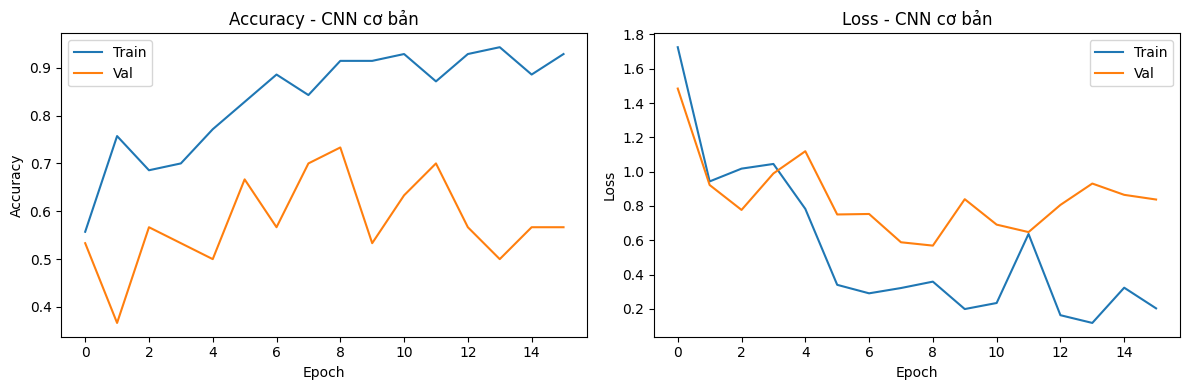

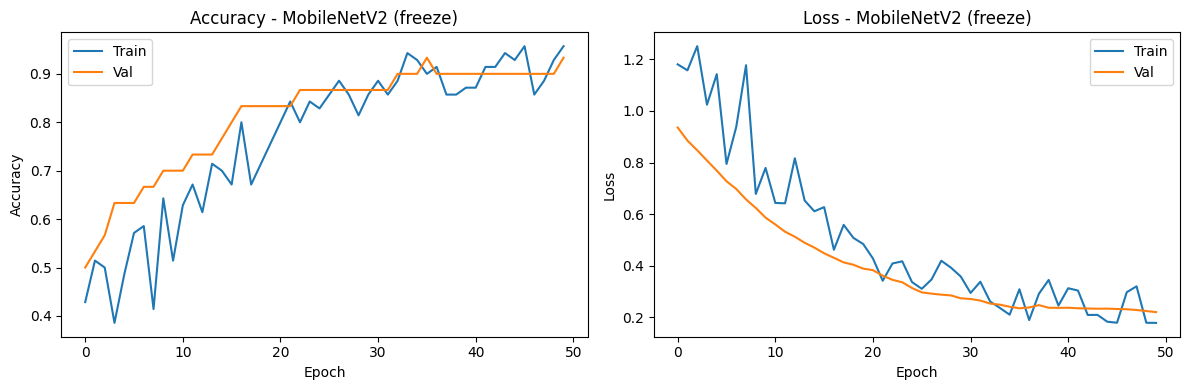

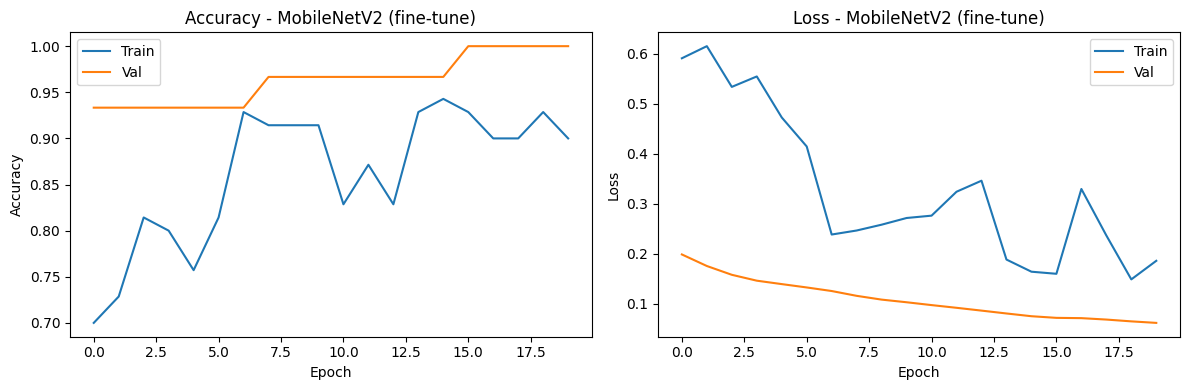

In [ ]:
# Vẽ đồ thị accuracy và loss theo epoch
def ve_do_thi_hoc(history, tieu_de: str):
    if history is None:
        return

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train')
    plt.plot(history.history.get('val_accuracy', []), label='Val')
    plt.title('Accuracy - ' + tieu_de)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train')
    plt.plot(history.history.get('val_loss', []), label='Val')
    plt.title('Loss - ' + tieu_de)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


ve_do_thi_hoc(lich_su_cnn, 'CNN cơ bản')
ve_do_thi_hoc(lich_su_mn_1, 'MobileNetV2 (freeze)')
ve_do_thi_hoc(lich_su_mn_2, 'MobileNetV2 (fine-tune)')

CNN cơ bản: Train accuracy tăng nhanh

Validation accuracy:
- Dao động mạnh (lên xuống liên tục)
- Không ổn định
- Loss
- Train loss giảm rất nhanh 

Validation loss:
- Giảm ban đầu
- Sau đó dao động + tăng nhẹ

-> Overfitting rõ ràng

Vì: Mô hình học rất tốt trên tập train,nhưng không tổng quát được cho dữ liệu mới,dataset nhỏ + đặc trưng âm thanh phức tạp

MobileNetV2:

Accuracy
- Train & Validation accuracy tăng đều
- Hai đường đi khá sát nhau
- Cuối đạt ~0.9

Loss
- Train & Val loss cùng giảm
- Không tách xa nhau
- Không bật ngược

-> Học ổn định – tổng quát tốt

-> Đây là baseline tốt nhất trong ba mô hình

MobileNetV2 (fine-tune)

Accuracy: 
- Validation accuracy lên rất cao
- Train accuracy thấp hơn validation

Loss
- Validation loss giảm đều và rất thấp
- Train loss dao động mạnh

Kết luận:
- Mô hình CNN cơ bản cho thấy dấu hiệu overfitting khi độ chính xác trên tập huấn luyện tăng nhanh trong khi độ chính xác trên tập kiểm tra dao động và không ổn định.
- MobileNetV2 với backbone đóng băng thể hiện quá trình học ổn định hơn, các đường accuracy và loss của train và validation gần nhau, cho thấy khả năng tổng quát tốt.
- Khi fine-tune MobileNetV2, validation accuracy đạt giá trị rất cao trong khi train accuracy thấp hơn, hiện tượng này xuất phát từ việc áp dụng data augmentation trên tập huấn luyện và kích thước tập validation nhỏ, không phải do lỗi mô hình.